# NWA suntans: enstrophy low vs high, maps

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
dcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from xhistogram.xarray import histogram

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    #cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=10)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [3]:
_, grd = nwa.load_surf()

zarr = os.path.join(nwa.suntans_dir, "suntans_2km_surf_gradients")
ds = xr.open_zarr(zarr)

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_gradients")
ds_low = xr.open_zarr(zarr)

f = pin.geo.coriolis(ds.yv)

# focus on enstrophy for now
ds["vorticity"] = (ds["dvcdx"] - ds["ducdy"])/f
ds_low["vorticity"] = (ds_low["dvcdx"] - ds_low["ducdy"])/f

ds = ds[["vorticity"]].persist()
ds_low = ds_low[["vorticity"]].persist()

---
## histograms

In [7]:
# max is 1e-16
#error = np.abs(ds["ke_total"] - ds["ke_mean"] - ds["ke_low"] - ds["ke_high"])
#error.plot.hist(bins=bins, color="k")

In [17]:
bins = np.arange(-2, 2., .05)
hkwargs = dict(bins=bins, bin_dim_suffix='', keep_coords=True)

In [19]:
h = histogram(ds["vorticity"], dim=["time"], **hkwargs).persist()
h_global = histogram(ds["vorticity"], **hkwargs).persist()

In [20]:
h_low = histogram(ds_low["vorticity"], dim=["time"], **hkwargs).persist()
h_low_global = histogram(ds_low["vorticity"], **hkwargs).persist()

In [21]:
#histogram?

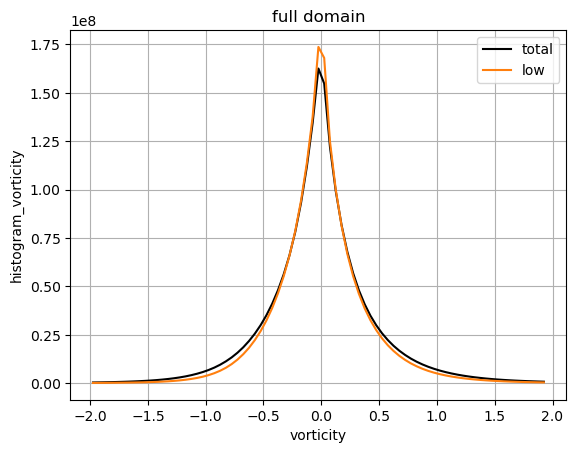

In [23]:
fig, ax = plt.subplots(1,1)

h_global.plot(ax=ax, color="k", label="total")
h_low_global.plot(ax=ax, color=dcolors[1], label="low")

ax.legend()
#ax.set_yscale("log")
ax.set_title("full domain")
ax.grid()

In [25]:
_h = nwa.zoom(h, nwa.area_cp).sum("Nc")
_h_low = nwa.zoom(h_low, nwa.area_cp).sum("Nc")

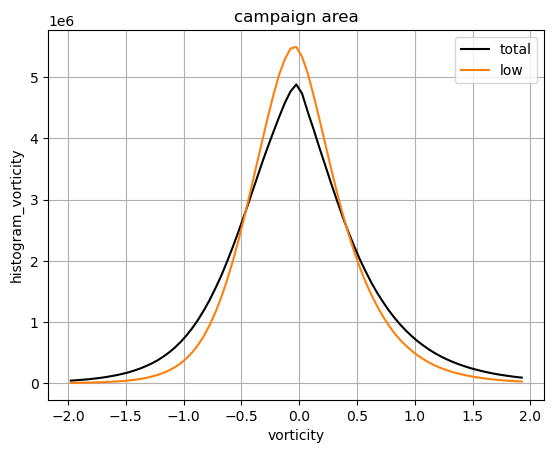

In [26]:
fig, ax = plt.subplots(1,1)

_h.plot(ax=ax, color="k", label="total")
_h_low.plot(ax=ax, color=dcolors[1], label="low")

ax.legend()
#ax.set_yscale("log")
ax.set_title("campaign area")
ax.grid()

### compute skewness

In [37]:
def skewness(h, dim="vorticity"):
    N = h.sum(dim)
    mean = h.sum(dim)/N
    std = np.sqrt( (h*(h.vorticity-mean)**2 ).sum(dim)/N )
    sk = (h*((h.vorticity-mean)/std)**3).sum(dim)/N
    return sk, std, mean

sk, std, mean = skewness(_h)

In [38]:
sk.compute(), std.compute(), mean.compute()

(<xarray.DataArray ()>
 array(-1.27624456),
 <xarray.DataArray ()>
 array(1.16603624),
 <xarray.DataArray 'histogram_vorticity' ()>
 array(1.))

<xarray.DataArray ()>
array(-1.27624456)

## time averaged enstrophy

In [39]:
ds["vorticity2_mean"] = (ds["vorticity"]**2).mean("time").persist()
ds_low["vorticity2_mean"] = (ds_low["vorticity"]**2).mean("time").persist()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

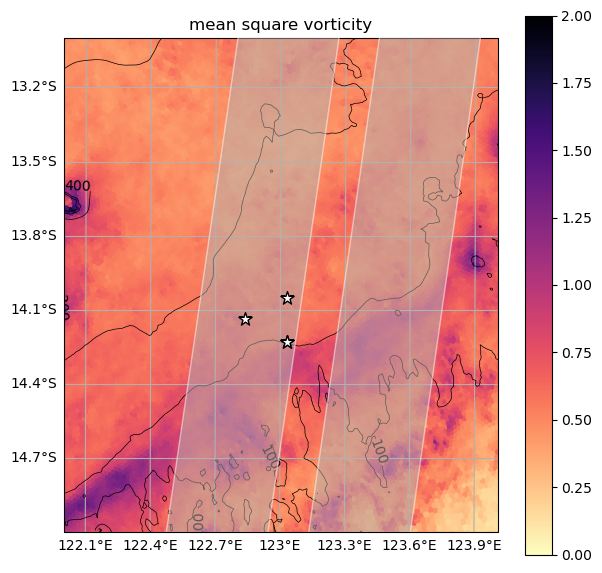

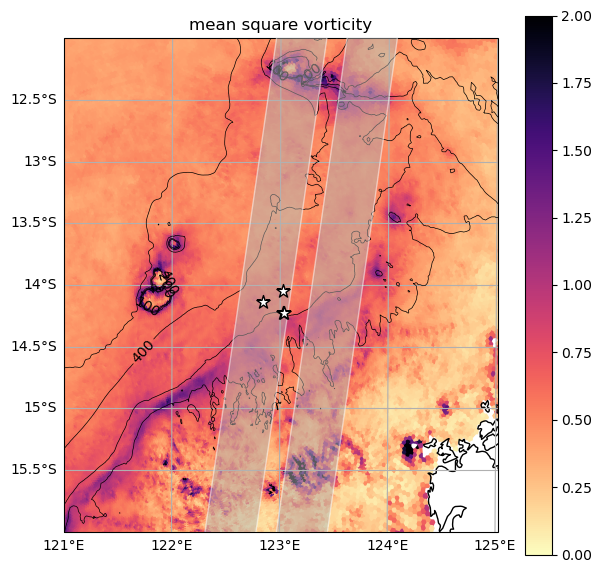

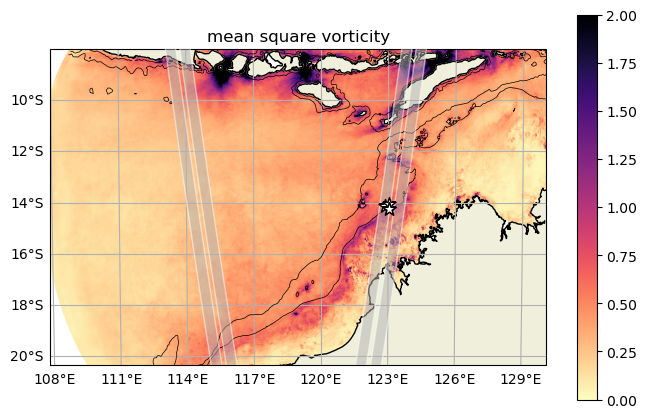

In [42]:
da = np.sqrt(ds["vorticity2_mean"])

for zoom in ["cp", "cp_large", "large"]:
    fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
    nwa.plot_moorings(ax)
    _, _, poly, cbar = grd.suntans.plotcelldata(da, vmin=0., vmax=2., cmap='magma_r', crs=crs)
    ax.set_title(f"mean square vorticity")

---

In [43]:
cluster.close()